# Lab 2: Cats vs Dogs

**Deadline**: January 30, 11:59pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**Marking TA**: Tinglin (Francis) Duan

This lab is partially based on an assignment developed by Prof. Jonathan Rose and Harris Chan.

In this lab, you will train a convolutional neural network to classify an image 
into one of two classes: "cat" or "dog". The code for the neural networks 
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://drive.google.com/file/d/13ct5EFbxv1HnZpQBHHBNS_QHZ2Mj4rrv/view?usp=sharing


In [0]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [0]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Returns the indices for datapoints in the dataset that
    belongs to the desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_train_indices = get_relevant_indices(
            trainset,
            classes,
            target_classes)
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_train_indices)
    split = int(len(relevant_train_indices) * 0.8)
    
    relevant_train_indices, relevant_val_indices = relevant_train_indices[:split], relevant_train_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. 
We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [0]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch


0it [00:00, ?it/s]

170500096it [00:02, 71743226.40it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

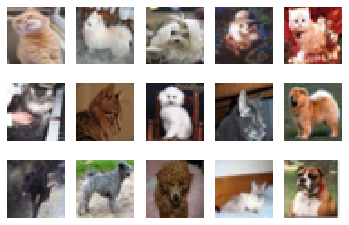

In [0]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img/2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

In [0]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

8000
2000
2000


(1) 8000

(2) 2000

(3) 2000

### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?

(1) Validation dataset is a sample of data held back from training our model that is used to give an estimate of model while tuning model’s hyperparameters. 
Validation dataset can provides an unbiased evaluation of a model fit on the training dataset. 

(2) The result can not show the performance of our models correctly. Because we use training data set to build model and it is used lots of times, the result may overfit the training data set and thus can not be regarded as an reliable result. 

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [0]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [0]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [0]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values. 

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [0]:
i = 0
for param in small_net.parameters():
    print(param.shape)
    i+=param.nelement()
print("\n")
j = 0
for param in large_net.parameters():
    print(param.shape)
    j+=param.nelement()

print(i)
print(j)

torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])


torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])
386
9705


**Answer: small_net has 386 parameters and large_net has 9705 parameters**

### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [0]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?

**Answer: batch_size=64, learning_rate=0.01, num_epochs=30**

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [0]:
train_net(small_net, batch_size=64, learning_rate=0.01, num_epochs=5)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43925, Train loss: 0.6837761921882629 |Validation err: 0.3915, Validation loss: 0.6662304606288671
Epoch 2: Train err: 0.381, Train loss: 0.652765160560608 |Validation err: 0.3935, Validation loss: 0.6627063862979412
Epoch 3: Train err: 0.342125, Train loss: 0.6253410925865174 |Validation err: 0.3345, Validation loss: 0.6184742171317339
Epoch 4: Train err: 0.324375, Train loss: 0.605528742313385 |Validation err: 0.3365, Validation loss: 0.6166710276156664
Epoch 5: Train err: 0.314125, Train loss: 0.5930196568965912 |Validation err: 0.32, Validation loss: 0.6095920111984015
Finished Training
Total time elapsed: 17.42 seconds


**Answer:** 

model_small_bs64_lr0.01_epoch0

model_small_bs64_lr0.01_epoch1

model_small_bs64_lr0.01_epoch2

model_small_bs64_lr0.01_epoch3

model_small_bs64_lr0.01_epoch4

model_small_bs64_lr0.01_epoch4_train_err.csv

model_small_bs64_lr0.01_epoch4_train_loss.csv

model_small_bs64_lr0.01_epoch4_val_err.csv

model_small_bs64_lr0.01_epoch4_val_loss.csv

**The first five files store the change of parameter value after each epoch.** 
**The csv files contain the train err, train loss, validation err, validation loss of each epoch.**

### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [0]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
train_net(small_net)
train_net(large_net)


Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.430875, Train loss: 0.676471375465393 |Validation err: 0.3885, Validation loss: 0.6602837760001421
Epoch 2: Train err: 0.37675, Train loss: 0.6532456545829773 |Validation err: 0.402, Validation loss: 0.6642627157270908
Epoch 3: Train err: 0.360875, Train loss: 0.6367706074714661 |Validation err: 0.3435, Validation loss: 0.628994869068265
Epoch 4: Train err: 0.335875, Train loss: 0.6199064631462097 |Validation err: 0.3585, Validation loss: 0.6300030741840601
Epoch 5: Train err: 0.33275, Train loss: 0.6100237321853638 |Validation err: 0.3235, Validation loss: 0.6175540648400784
Epoch 6: Train err: 0.32025, Train loss: 0.5985852217674256 |Validation err: 0.3185, Validation loss: 0.6122824549674988
Epoch 7: Train err: 0.318, Train loss: 0.5926340355873108 |Validation err: 0.3275, Validation loss: 0.6091931974515319
Epoch 8: Train err: 0.31, Train loss: 0.5866195507049561 |Validation err: 0.324

**Answer:**

The total time elapsed for small_net train is 104.17 seconds.

The total time elapsed for large_net train is 121.36 seconds. 

Because large network has more layers and trainable parameters than small network



### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

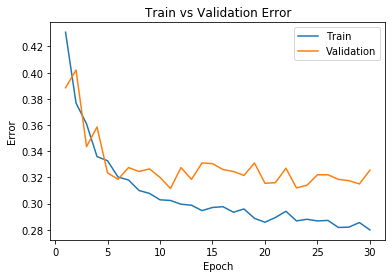

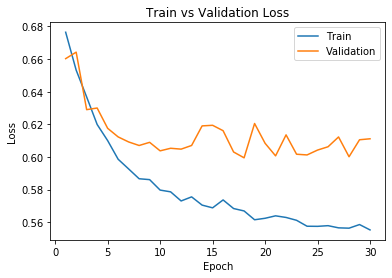

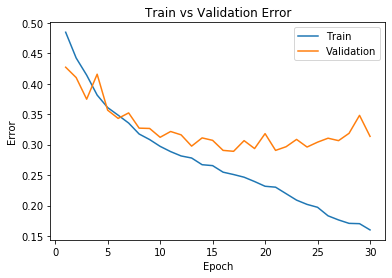

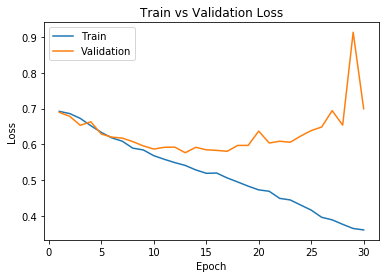

In [0]:
small_model_path = get_model_name("small",batch_size=64, learning_rate=0.01, epoch=29)
large_model_path = get_model_name("large",batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(small_model_path)
plot_training_curve(large_model_path)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

**Answer:**

For both network, the training curves keep going down because we keep training the ANN use same training data and the network is already familiar with this specific type of data.  

For small network curve, the underfitting area is between 0 to 6 epoch. Because in this area, the training and validation curve both go down and the error&loss rate are still very high, which means the ANN underfit the training data. The overfitting happened between 8 to 30 epoch. Because in this area the training error rate is already very low and but the validation error rate is still high and keep moving upward and downward, which means the network overfit the training data.

For large network curve, the underfitting area is between 0 to 10 epoch. 
The overfitting happened between 10 to 30 epoch. The reason why the large network takes more epochs to train the data is because large network has more layers compared with small network.


## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.502625, Train loss: 0.6934512100219726 |Validation err: 0.4915, Validation loss: 0.6924004089087248
Epoch 2: Train err: 0.502, Train loss: 0.6927555685043335 |Validation err: 0.479, Validation loss: 0.6919200755655766
Epoch 3: Train err: 0.46825, Train loss: 0.692239456653595 |Validation err: 0.4505, Validation loss: 0.6915876045823097
Epoch 4: Train err: 0.446625, Train loss: 0.691767499923706 |Validation err: 0.433, Validation loss: 0.6909000761806965
Epoch 5: Train err: 0.442875, Train loss: 0.6912033386230468 |Validation err: 0.428, Validation loss: 0.6905545238405466
Epoch 6: Train err: 0.439625, Train loss: 0.6905257019996643 |Validation err: 0.4285, Validation loss: 0.6896730232983828
Epoch 7: Train err: 0.438875, Train loss: 0.6896908254623413 |Validation err: 0.427, Validation loss: 0.6887361221015453
Epoch 8: Train err: 0.436625, Train loss: 0.6885663132667541 |Validation err: 0.

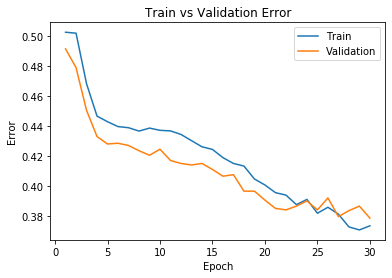

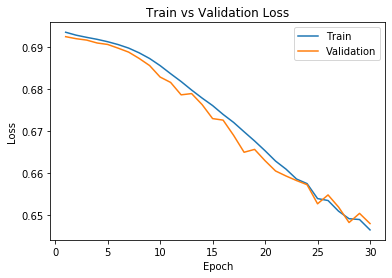

In [0]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, learning_rate=0.001)
large_model_path = get_model_name("large",batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(large_model_path)

**Answer:**

The model takes **longer** to train as can be viewed by comparing error and loss rate of the new curve and orginal curve at the point of 30 epoch. 

**Lowering the learning rate increase the training time and improve the validation accuracy.** As shown in the graph, both validation & training error keep going down, and the the gap between validation & training result becomse extremely small during most of epochs, which means the optimization is effective and the model performs well. 

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4475, Train loss: 0.6911942834854126 |Validation err: 0.436, Validation loss: 0.6845365408807993
Epoch 2: Train err: 0.413, Train loss: 0.6768139729499817 |Validation err: 0.4215, Validation loss: 0.6781298108398914
Epoch 3: Train err: 0.391, Train loss: 0.6603508977890015 |Validation err: 0.376, Validation loss: 0.6463533267378807
Epoch 4: Train err: 0.363375, Train loss: 0.6390478830337525 |Validation err: 0.362, Validation loss: 0.6331797130405903
Epoch 5: Train err: 0.344375, Train loss: 0.616078978061676 |Validation err: 0.3335, Validation loss: 0.6130770370364189
Epoch 6: Train err: 0.317875, Train loss: 0.5917085156440735 |Validation err: 0.323, Validation loss: 0.6027600802481174
Epoch 7: Train err: 0.30225, Train loss: 0.5793282585144043 |Validation err: 0.3165, Validation loss: 0.5915854163467884
Epoch 8: Train err: 0.301625, Train loss: 0.5675516674518585 |Validation err: 0.315,

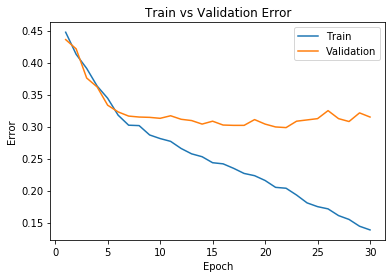

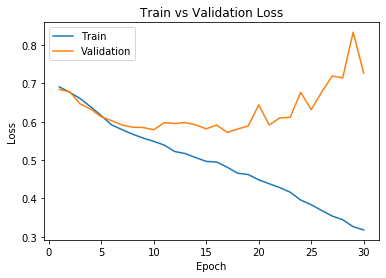

In [0]:
large_net = LargeNet()
train_net(large_net, learning_rate=0.01)
large_model_path = get_model_name("large",batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(large_model_path)

**Answer:**

The model takes **shorter** to train. 

**Increasing the learning rate reduce the training time, but lower the validation accuracy**. The underfitting interval becomes 0-10 epochs and the gap between validation and training result becomse larger. 

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379440844059 |Validation err: 0.478, Validation loss: 0.6926823854446411
Epoch 2: Train err: 0.457625, Train loss: 0.6924103908240795 |Validation err: 0.434, Validation loss: 0.6917424947023392
Epoch 3: Train err: 0.437, Train loss: 0.6916500329971313 |Validation err: 0.4265, Validation loss: 0.6909129470586777
Epoch 4: Train err: 0.433625, Train loss: 0.6908449530601501 |Validation err: 0.424, Validation loss: 0.6897872388362885
Epoch 5: Train err: 0.433875, Train loss: 0.6896938420832157 |Validation err: 0.424, Validation loss: 0.6881361752748489
Epoch 6: Train err: 0.438375, Train loss: 0.6883538104593754 |Validation err: 0.4285, Validation loss: 0.6860138773918152
Epoch 7: Train err: 0.4395, Train loss: 0.6866881810128689 |Validation err: 0.426, Validation loss: 0.6836974024772644
Epoch 8: Train err: 0.43525, Train loss: 0.6849779076874256 |Validation err: 0.41

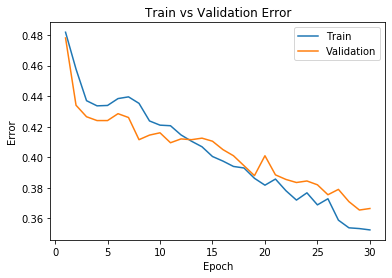

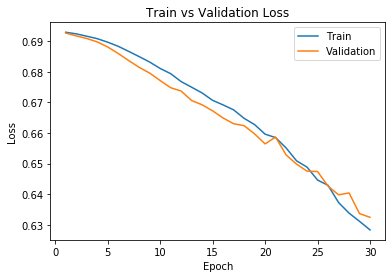

In [0]:
large_net = LargeNet()
train_net(large_net, batch_size=512, learning_rate=0.01)
large_model_path = get_model_name("large",batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(large_model_path)

**Answer:**

The model takes **shorter** to train.

**The validation accuracy becomes higher**. As shown in the graph, both validation & training error keep going down, and the the gap between validation & training result becomse extremely small during most of epochs, which means the optimization is effective and the CNN perform better and better.


### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.431625, Train loss: 0.6775330043435097 |Validation err: 0.3775, Validation loss: 0.6519424777030944
Epoch 2: Train err: 0.367625, Train loss: 0.6392622269392013 |Validation err: 0.348, Validation loss: 0.6155767557621002
Epoch 3: Train err: 0.339125, Train loss: 0.611388805270195 |Validation err: 0.3535, Validation loss: 0.6442605230808258
Epoch 4: Train err: 0.31, Train loss: 0.5834368724226952 |Validation err: 0.358, Validation loss: 0.627853533744812
Epoch 5: Train err: 0.30625, Train loss: 0.5661577586531639 |Validation err: 0.316, Validation loss: 0.5802795274257659
Epoch 6: Train err: 0.280625, Train loss: 0.5455610679984093 |Validation err: 0.305, Validation loss: 0.5808147265911102
Epoch 7: Train err: 0.268, Train loss: 0.5272379929423332 |Validation err: 0.3215, Validation loss: 0.5912406492233276
Epoch 8: Train err: 0.262875, Train loss: 0.5096900141835212 |Validation err: 0.305,

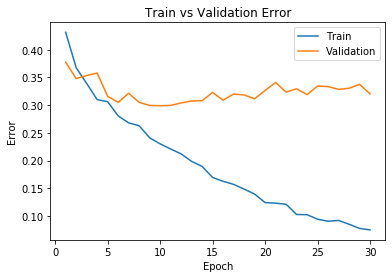

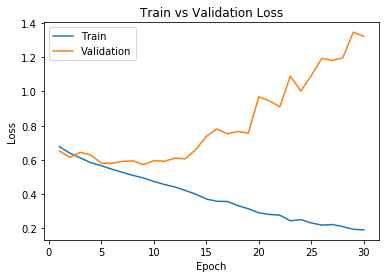

In [0]:
large_net = LargeNet()
train_net(large_net, batch_size=16, learning_rate=0.01)
large_model_path = get_model_name("large",batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(large_model_path)


**Answer:** 

The model takes **longer** to train.

**The validation accuracy becomes lower.** As shown in the graph, from 5 epoch, the mpdel start overfiting the data as the gap between training & validation result becomes larger and larger, which means the optimization of each epoch doesn't perform effectively on the model.

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

**Answer:**

I would like to choose **large_net, learning_rate = 0.001 and batch_size = 32.** Because as can be seen in the result of part3, lowering learning_rate and batch_size can help lower the validation accuracy of the CNN and avoid overfitting the data.

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.466125, Train loss: 0.6925730061531067 |Validation err: 0.4335, Validation loss: 0.6916963760814969
Epoch 2: Train err: 0.447, Train loss: 0.6912713775634766 |Validation err: 0.4235, Validation loss: 0.6898156773476374
Epoch 3: Train err: 0.4345, Train loss: 0.6893715627193451 |Validation err: 0.418, Validation loss: 0.6867548936889285
Epoch 4: Train err: 0.43275, Train loss: 0.6866880621910095 |Validation err: 0.42, Validation loss: 0.6824120756179567
Epoch 5: Train err: 0.425875, Train loss: 0.6837930774688721 |Validation err: 0.413, Validation loss: 0.6795155774979365
Epoch 6: Train err: 0.419125, Train loss: 0.6804859852790832 |Validation err: 0.411, Validation loss: 0.675978646391914
Epoch 7: Train err: 0.41225, Train loss: 0.6771764488220214 |Validation err: 0.4145, Validation loss: 0.672963385544126
Epoch 8: Train err: 0.409375, Train loss: 0.6737022876739502 |Validation err: 0.41, 

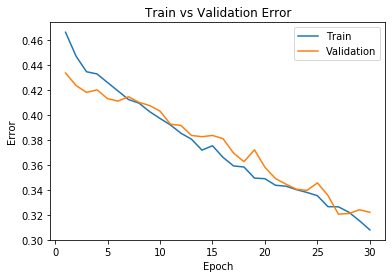

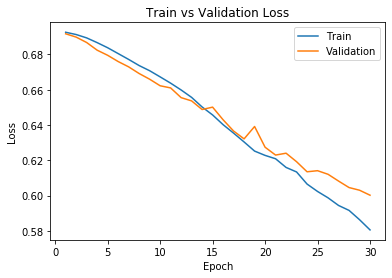

In [0]:
large_net = LargeNet()
train_net(large_net, batch_size=32, learning_rate=0.001)
large_model_path = get_model_name("large",batch_size=32, learning_rate=0.001, epoch=29)
plot_training_curve(large_model_path)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.

**Answer:**

I would like to choose **small_net, learning_rate = 0.001 and batch_size = 32.** Because as can be seen in the result of part3, lowering learning_rate and batch_size can help improve the optimization effect of the ANN and avoid overfitting the data. A small_net has a shorter training time and less variance to the model compared with large_net. So I would like to compare the differnece between small_net and large_net and keep other hyperparameters the same with above.

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Using downloaded and verified file: ./data/cifar-10-python.tar.gz
Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch 1: Train err: 0.457875, Train loss: 0.6881250672340393 |Validation err: 0.414, Validation loss: 0.6742530767879789
Epoch 2: Train err: 0.4035, Train loss: 0.6693206088542938 |Validation err: 0.3835, Validation loss: 0.6669945149194627
Epoch 3: Train err: 0.38125, Train loss: 0.657546222448349 |Validation err: 0.369, Validation loss: 0.6511996539812239
Epoch 4: Train err: 0.370125, Train loss: 0.6489880259037017 |Validation err: 0.3655, Validation loss: 0.6451390404549856
Epoch 5: Train err: 0.3645, Train loss: 0.6428525183200836 |Validation err: 0.3665, Validation loss: 0.6415877682822091
Epoch 6: Train err: 0.361, Train loss: 0.6375455008745193 |Validation err: 0.366, Validation loss: 0.6386493037617396
Epoch 7: Train err: 0.353375, Train loss: 0.6347734111547471 |Validation err: 0.356, Validation loss: 0.6360362654640561
Epoc

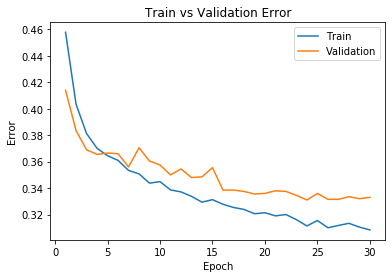

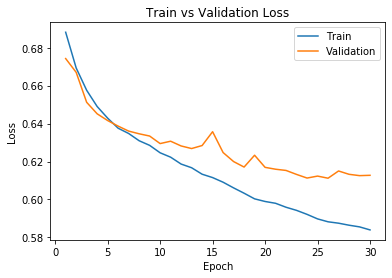

In [0]:
small_net = SmallNet()
train_net(small_net, batch_size=32, learning_rate=0.001)
small_model_path = get_model_name("small",batch_size=32, learning_rate=0.001, epoch=29)
plot_training_curve(small_model_path)

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [0]:
net = LargeNet()
train_net(net, batch_size=32, learning_rate=0.001)
model_path = get_model_name(net.name, batch_size=32, learning_rate=0.001, epoch=29)
state = torch.load(model_path)
net.load_state_dict(state)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.499, Train loss: 0.693377732038498 |Validation err: 0.4825, Validation loss: 0.6918159893580845
Epoch 2: Train err: 0.473875, Train loss: 0.6914404072761535 |Validation err: 0.432, Validation loss: 0.6898769424075172
Epoch 3: Train err: 0.437375, Train loss: 0.6891052825450897 |Validation err: 0.4235, Validation loss: 0.6863164551674373
Epoch 4: Train err: 0.4355, Train loss: 0.6855380482673645 |Validation err: 0.4205, Validation loss: 0.6803906209885128
Epoch 5: Train err: 0.428875, Train loss: 0.6817091896533966 |Validation err: 0.41, Validation loss: 0.6767391515156579
Epoch 6: Train err: 0.421125, Train loss: 0.6778606283664703 |Validation err: 0.4145, Validation loss: 0.6734432417248922
Epoch 7: Train err: 0.410375, Train loss: 0.6745539553165436 |Validation err: 0.4035, Validation loss: 0.670302775171068
Epoch 8: Train err: 0.408125, Train loss: 0.6711023683547974 |Validation err: 0.

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

**Answer:**

Based on my observation from the last part, I found that the validation accuracy of large_net is higher than small_net for the same choice of other hyperparameters(batch_size, learning_rate). In addition, I kept changing the different value of the learning_rate and batch_size, and found that the combination of learning_rate = 0.001 & batch_size = 32 can result the best validation accuracy. As shown in the last part, the gap between validation and training error curve are very small, which means the model experiences a good fit of data.

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [0]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=32)
criterion = nn.BCEWithLogitsLoss()
test_error = evaluate(net, test_loader, criterion)[0]
val_error = evaluate(net, val_loader, criterion)[0]
print("Test error is %.3f" % test_error)
print("Validation error is %.3f" % val_error)



Files already downloaded and verified
Files already downloaded and verified
Test error is 0.307
Validation error is 0.324


**Answer:**

Test error is 0.307

### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

**Answer:**

Test error is higher than validation error. Because we need to keep using validation data in every epoch to compute the validation error&loss to tune our hyperparameter. Thus, when the network is fully-trained, it has used the same validation data many times and already fit the data. On the other hand, we only use the test data once at the very end to matter the performace of our network, which results in a higher test error than validation error.


### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

**Answer:**

Test data is a set of examples used only to monitor a real situation and measure the performance of a fully-trained network. We would like to use the test data as little as possible to improve the test accuracy and avoid making the network overfits the test data. We should keep training our model with training data set and tuning our hyperparameter based on validation error until we reach the best performance of the network. Then, we can test the performance of our fully-trained model with test data set at the very end. 

### Part (f) - 5pt

Train a 2-layer ANN similar to what was used in Lab 1 to classific cats and dogs. Try out different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data. How does the ANN model compare to your CNN model?

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.41175, Train loss: 0.6699168617725373 |Validation err: 0.3945, Validation loss: 0.6579368890277923
Epoch 2: Train err: 0.386125, Train loss: 0.6509542284011841 |Validation err: 0.392, Validation loss: 0.6536242422603425
Epoch 3: Train err: 0.370125, Train loss: 0.6411963832378388 |Validation err: 0.3875, Validation loss: 0.6488626145181202
Epoch 4: Train err: 0.362, Train loss: 0.6333737645149231 |Validation err: 0.392, Validation loss: 0.6551948199196468
Epoch 5: Train err: 0.35175, Train loss: 0.6279940575361251 |Validation err: 0.378, Validation loss: 0.645237147808075
Epoch 6: Train err: 0.345375, Train loss: 0.620483977675438 |Validation err: 0.385, Validation loss: 0.6458511484993829
Epoch 7: Train err: 0.3335, Train loss: 0.6148893773555756 |Validation err: 0.379, Validation loss: 0.6441525637157379
Epoch 8: Train err: 0.3315, Train loss: 0.6079933977127076 |Validation err: 0.373, V

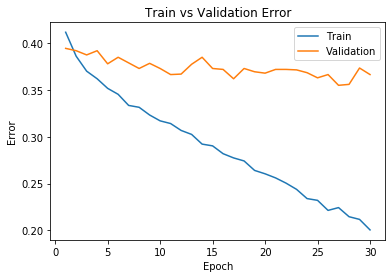

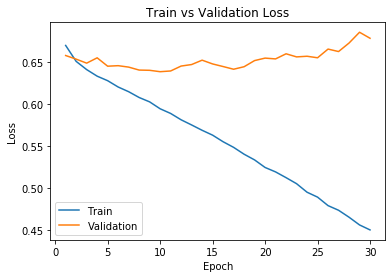

Test error is 0.372


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim

torch.manual_seed(1) # set the random seed

# define a 2-layer artificial neural network
class Pigeon(nn.Module):
    def __init__(self):
        super(Pigeon, self).__init__()
        self.name = "pigeon"
        self.layer1 = nn.Linear(32 * 32 * 3, 30) 
        self.layer2 = nn.Linear(30, 1)
        
        # here we can add more layers
        # self.layer1_1 = nn.Linear(30, 30) 
        # self.layer1_2 = nn.Linear(30, 30)   
    def forward(self, img):
        flattened = img.view(-1, 32 * 32 * 3)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)   
        activation2 = self.layer2(activation1)
        activation2 = activation2.squeeze(1)

        # activation1_1 = self.layer1_1(activation1)
        # activation1_1 = F.relu(activation1_1)
        # activation1_2 = self.layer1_2(activation1_1)
        # activation1_2 = F.relu(activation1_2)
        # activation2 = self.layer2(activation1_2)
        return activation2

pigeon = Pigeon()

train_net(pigeon, batch_size=32, learning_rate=0.001, num_epochs=30)
pigeon_model_path = get_model_name("pigeon",batch_size=32, learning_rate=0.001, epoch=29)
plot_training_curve(pigeon_model_path)

criterion = nn.BCEWithLogitsLoss()
test_error = evaluate(pigeon, test_loader, criterion)[0]
print("Test error is %.3f"%test_error)

**Answer:**

**For change in batch_size:**

**Hyper Parameter:** batch_size=32, learning_rate=0.01, num_epochs=30

**Result:** Epoch 30: Train err: 0.200375, Train loss: 0.4504455338716507 |Validation err: 0.3665, Validation loss: 0.678469285132393

**Hyper Parameter:** batch_size=64, learning_rate=0.01, num_epochs=30

**Result:** Epoch 30: Train err: 0.109875, Train loss: 0.26614615213871 |Validation err: 0.377, Validation loss: 1.0368482191115618

**Hyper Parameter:** batch_size=128, learning_rate=0.01, num_epochs=30

**Result:** Epoch 30: Train err: 0.135875, Train loss: 0.3135287730939805 |Validation err: 0.3625, Validation loss: 0.86328961327672

**Hyper Parameter:** batch_size=256, learning_rate=0.01, num_epochs=30

**Result:** Epoch 30: Train err: 0.187125, Train loss: 0.41880595963448286 |Validation err: 0.3625, Validation loss: 0.703630693256855

**Hyper Parameter:** batch_size=512, learning_rate=0.01, num_epochs=30

**Result:** Epoch 30: Train err: 0.251875, Train loss: 0.5218319464474916 |Validation err: 0.369, Validation loss: 0.6501501202583313




**For change in learning_rate:**

**Hyper Parameter:** batch_size=32, learning_rate=0.005, num_epochs=30

**Result:** Epoch 30: Train err: 0.142, Train loss: 0.33660449302196505 |Validation err: 0.369, Validation loss: 0.8793205376714468

**Hyper Parameter:** batch_size=32, learning_rate=0.004, num_epochs=30

**Result:** Epoch 30: Train err: 0.16, Train loss: 0.36590190637111664 |Validation err: 0.366, Validation loss: 0.7807380398735404

**Hyper Parameter:** batch_size=32, learning_rate=0.003, num_epochs=30

**Result:** Epoch 30: Train err: 0.14425, Train loss: 0.3377722234725952 |Validation err: 0.3775, Validation loss: 0.9784398750653343

**Hyper Parameter:** batch_size=32, learning_rate=0.002, num_epochs=30

**Result:** Epoch 30: Train err: 0.15775, Train loss: 0.36726920640468597 |Validation err: 0.3705, Validation loss: 0.8195293928895678

**Hyper Parameter:** batch_size=32, learning_rate=0.001, num_epochs=30

**Result:** Epoch 30: Train err: 0.22225, Train loss: 0.4772487304210663 |Validation err: 0.3595, Validation loss: 0.6729491173274933

Based on the data above, I found that ANN curve start overfitting even from the 1st epoch, which results in a bad validation accuracy at the end of the 30 epochs. The best valiadation error I can achieve was 0.3595 when I set batch_size=32 and learning_rate=0.001. 

By using the same hyperparameter lr = 0.001, batch_size = 32, and epoch = 30, it is easy to find that **the ANN's test error(0.372) is higher than CNN's test error(0.307)**. Because for ANN, it has only two layers and set a weight for every input pixel, which results in a high test error.
